### Introduction

This notebook explores the [SteamSpy API](https://steamspy.com/api.php) which contains data on the titles included in the [Steam Store](https://store.steampowered.com/) catalog.

This project seeks to answer core questions about the PC gaming market, with a special focus on the dynamics between AAA and Indie titles. My goal is to first understand the general layout of the API, practicing calling from it. Then, I will begin to perform some data exploration to probe existing patterns. I will then perform data analysis to test the hypotheses that I have formed:

- **Pricing & Popularity:** What is the average price of a "Top 10" selling game, and how does this differ between AAA and Indie titles?
- **Sales & Promotions:** Is there a clear correlation between a game's discount percentage and a surge in its concurrent player count?
- **Genre Dominance:** Which genres (e.g., "Indie," "RPG," "Strategy") are most consistently represented in the top 100 selling games over time?
- **Sentiment & Success:** How do user review scores (specifically the ratio of Positive to Negative reviews) affect a game's long-term sales rank and player retention?

Once I have answered my questions, I will develop a dashboard integration to further monitor the status of relevant metrics.

### API Integration

We first start by trying to access the API.

The API site is: https://steamspy.com/api.php

The navigation of the database is performed to the modification of parameters such as:

https://steamspy.com/api.php?request=appdetails&appid=730

In [1]:
# Installing required packages
# !pip install requests
# !pip install pandas
# !pip install matplotlib

In [2]:
# import packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math

#### Fetch Data

In [3]:
# Fetch data from the API
url = "https://steamspy.com/api.php"
params = {
    "request": "appdetails",
    "appid": "730"
}
response = requests.get(url, params=params)
data = response.json()

# Create a DataFrame for the main data
main_data = pd.DataFrame([data])

# display the data (transposed for better readability))
print("Main Data:")
print(main_data.T)

Main Data:
                                                                 0
appid                                                          730
name                              Counter-Strike: Global Offensive
developer                                                    Valve
publisher                                                    Valve
score_rank                                                        
positive                                                   7642084
negative                                                   1173003
userscore                                                        0
owners                                  100,000,000 .. 200,000,000
average_forever                                              30276
average_2weeks                                                 790
median_forever                                                5226
median_2weeks                                                  332
price                                              

#### Visualization of the Data

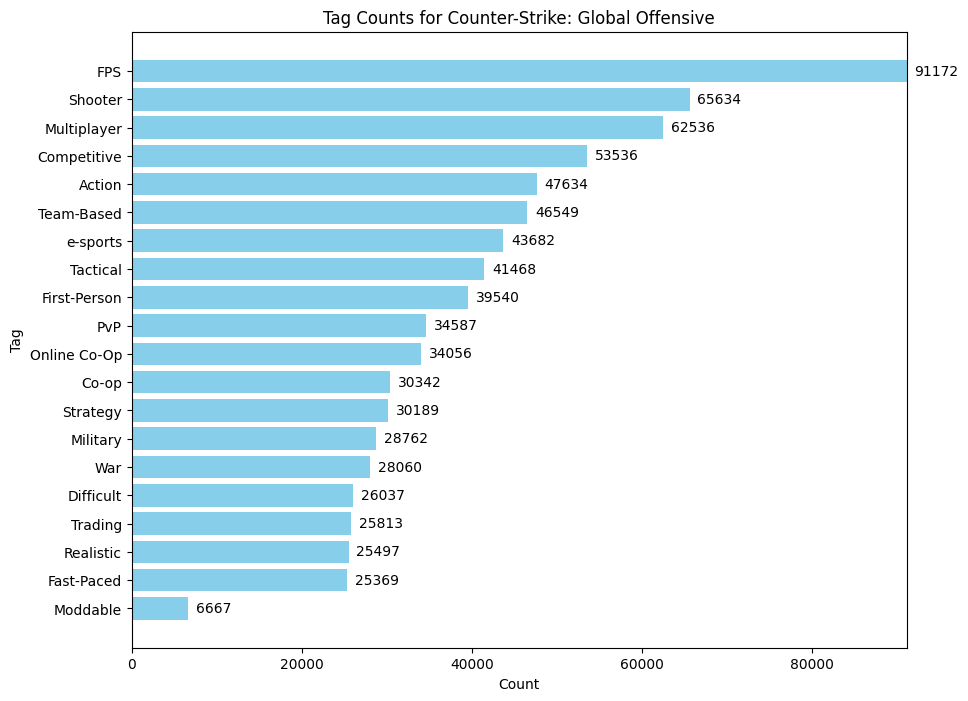

In [4]:
## --- VISUALIZATION OF TAGS ---

# Flatten the 'tags' dictionary
tags = data.pop("tags", {})
tags_df = pd.DataFrame(list(tags.items()), columns=['Tag Name', 'Count'])

# Sort tags by count descending
tags_df = tags_df.sort_values(by='Count', ascending=False)

# Find the max tag count and round up
max_count = tags_df['Count'].max()
max_count_rounded = math.ceil(max_count)

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(tags_df['Tag Name'], tags_df['Count'], color='skyblue')
plt.xlim(0, max_count_rounded)
plt.xlabel('Count')
plt.ylabel('Tag')
plt.title('Tag Counts for Counter-Strike: Global Offensive')

# Add count labels to the right end of each bar
for bar in bars:
    plt.text(
        bar.get_width() + max_count_rounded * 0.01,  # small offset
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width())}',
        va='center'
    )

plt.gca().invert_yaxis()  # Highest count at the top
plt.show()

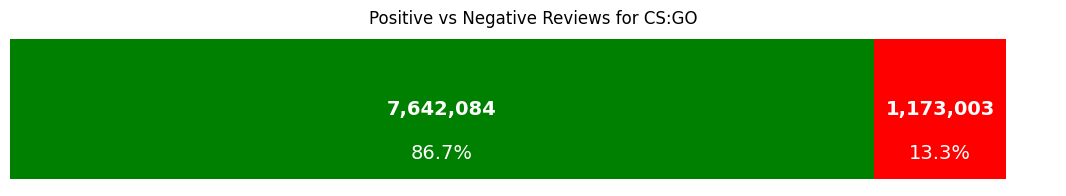

In [6]:
### --- VISUALIZATION OF POSITIVE AND NEGATIVE REVIEWS ---

# Extract positive and negative review counts
positive = data.get('positive', 0)
negative = data.get('negative', 0)
total = positive + negative

# Calculate the required width
max_text_len = max(len(f'{positive:,}'), len(f'{negative:,}'))
fig_width = max(8, max_text_len * 1.5)  # Adjust multiplier to change width

plt.figure(figsize=(fig_width, 2))
plt.barh([''], [positive], color='green')
plt.barh([''], [negative], left=[positive], color='red')

# Add count labels
plt.text(positive / 2, 0, f'{positive:,}', va='center', ha='center', color='white', fontweight='bold', fontsize=14)
plt.text(positive + negative / 2, 0, f'{negative:,}', va='center', ha='center', color='white', fontweight='bold', fontsize=14)

# Add % labels beneath each count
plt.text(positive / 2, -0.25, f"{positive/total:.1%}", va='center', ha='center', color='white', fontsize=14)
plt.text(positive + negative / 2, -0.25, f"{negative/total:.1%}", va='center', ha='center', color='white', fontsize=14)

# Remove axes and legend
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.box(False)
plt.title('Positive vs Negative Reviews for CS:GO')
plt.show()

### Downloading all data

Because the API has limits for querying data, and we want to do a lot of things with the data. We are going to set some time aside to pull all data from the API.

We need to be aware of the 1,000 entries per page and the 1 query per 60 seconds limitations. To do this we need to follow:

1. Start at page 0 and increment the page number.
2. Wait at least 60 seconds between requests (per API rules).
3. Stop when a page returns fewer than 1,000 results (or is empty).

The creator of the API made the note, which we will pay attention to: 

*"appid - Steam Application ID. If it's 999999, then data for this application is hidden on developer's request, sorry."*

We will aggregate all data under a single CSV for further analysis.

In [7]:
### --- OPTIONAL: Fetching the first page of SteamSpy data ---

# import requests
# import pandas as pd

# # Fetch the first page only
# url = "https://steamspy.com/api.php"
# params = {"request": "all", "page": 0}
# print("Fetching page 0...")
# response = requests.get(url, params=params)
# data = response.json()

# # Convert to DataFrame and save as CSV
# df = pd.DataFrame(data).T  # Transpose to get games as rows
# df.to_csv("steamspy_page0.csv", index=False)
# print("Saved first page to steamspy_page0.csv")

In [8]:
"""
Dump *all* public Steam Spy data into one CSV.

• First we page through /all (1 req / 60 s) to discover every appid.
• Then we call /appdetails (1 req / s) for the full payload.
• Each /appdetails response is appended as a CSV row immediately
  so RAM stays low even with ~75 k titles.

Run time ≈ 20 h on one thread.  Parallel workers are possible
as long as each keeps to the one-per-sec budget.
"""

import csv
import json
import time
import requests
from pathlib import Path

BASE = "https://steamspy.com/api.php"
ALL_RATE = 60          # seconds between “all” requests
DETAIL_RATE = 1.1      # seconds between “appdetails” requests (give ourselves a cushion)
OUTFILE = Path("steamspy_full_dump.csv")

# ---------- 1. Discover every public appid via /all ---------------------------
def iter_all_appids():
    page = 0
    while True:
        print(f"[all]  page {page} …", flush=True)
        r = requests.get(BASE, params={"request": "all", "page": page}, timeout=30)
        r.raise_for_status()
        payload = r.json()
        if not payload:
            break

        for app in payload.values():
            if str(app["appid"]) != "999999":        # skip hidden titles
                yield app["appid"]

        if len(payload) < 1000:                      # last page reached
            break
        page += 1
        time.sleep(ALL_RATE)

# ---------- 2. Stream full records via /appdetails ----------------------------
def fetch_details(appid):
    r = requests.get(BASE, params={"request": "appdetails", "appid": appid}, timeout=30)
    r.raise_for_status()
    return r.json()

# ---------- 3. Write to CSV ---------------------------------------------------
def dump_to_csv(appids):
    first_row = fetch_details(next(appids))  # peek to create header
    header = sorted(first_row.keys())
    with OUTFILE.open("w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=header)
        writer.writeheader()

        # write first row
        writer.writerow({k: json.dumps(v) if isinstance(v, (list, dict)) else v
                         for k, v in first_row.items()})

        # now process the rest
        for idx, appid in enumerate(appids, start=2):
            try:
                row = fetch_details(appid)
            except requests.RequestException as e:
                print(f"!!!  {appid}: {e}; skipping")
                continue

            # JSON-encode arrays / dicts so the CSV stays 1-col-per-field
            writer.writerow({k: json.dumps(v) if isinstance(v, (list, dict)) else v
                             for k, v in row.items()})

            if idx % 100 == 0:
                print(f"  …{idx:,} rows written", flush=True)

            time.sleep(DETAIL_RATE)

    print(f"✅ Finished. Output saved to {OUTFILE.absolute()}.")

# ----------------------------------------------------------------------------- 
if __name__ == "__main__":
    ids = iter_all_appids()
    dump_to_csv(ids)

[all]  page 0 …
  …100 rows written
  …200 rows written
  …300 rows written
  …400 rows written
  …500 rows written
  …600 rows written
  …700 rows written
  …800 rows written
  …900 rows written
  …1,000 rows written
[all]  page 1 …
  …1,100 rows written
  …1,200 rows written
  …1,300 rows written
  …1,400 rows written
  …1,500 rows written
  …1,600 rows written
  …1,700 rows written
  …1,800 rows written
  …1,900 rows written
  …2,000 rows written
[all]  page 2 …
  …2,100 rows written
  …2,200 rows written
  …2,300 rows written
  …2,400 rows written
  …2,500 rows written
  …2,600 rows written
  …2,700 rows written
  …2,800 rows written
  …2,900 rows written
  …3,000 rows written
[all]  page 3 …
  …3,100 rows written
  …3,200 rows written
  …3,300 rows written
  …3,400 rows written
  …3,500 rows written
  …3,600 rows written
  …3,700 rows written
  …3,800 rows written
  …3,900 rows written
  …4,000 rows written
[all]  page 4 …
  …4,100 rows written
  …4,200 rows written
  …4,300 rows 